次は、金融市場でありがちな戦略に基づいて売買して、その成績に応じて戦略をまねさせる、バージョンを作りたい

### 前提条件

・対数正規分布に従うような企業の規模の変動

・企業規模に比例した「均衡」株価

・採用する戦略の種類は、同時に一種類のみ

・採用する戦略内で、パラメータ調整。パラメータは独自に振動しつつ、収益率の高いエージェントの真似をする傾向も加える

・預金×レバレッジが、買うための資金源

・いずれの戦略でも、ポートフォリオ配分割合目標を持つ


### 戦略（案）

・ファンダメンタルズに応じて売買する。長期的戦略。

・テクニカル分析に応じて売買する。短期的戦略。

・テクニカル分析に応じて売買する。長期的戦略。


In [40]:
using StatsPlots
using Random
using Statistics

In [41]:
mutable struct Agent
    strategy::String
    money::Float64
    sharesQuantity  #   株式保有部数リスト
    sharesRetainedLine  #   株式保有金額のリスト
    total_assets_log    #   資産総額の履歴
    params  #   パラメータのリスト  
    #   ファンダメンタルズ戦略をとる場合 [ポートフォリオのうち預金の割合, 企業評価/時価総額　の、買いの閾値になる倍率, 企業価値/時価総額　の、売りの閾値になる倍率, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    #   インデックス戦略をとる場合      [ポートフォリオのうち預金の割合, 1期のタイムスケール, α5, α4, α3, α2, α1, α0, β1, β2, γ, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    fundamentals    #   企業評価のリスト    ファンダメンタルズ戦略をとる場合しか使わないが、更新はインデックス戦略をとるときでも続ける
    portfolio_target#   ポートフォリオ配分目標。[預金,株式]
    performance::Float64    #   運用成績
end
mutable struct Firm
    stockPrice::Float64     #   株価
    stockQuantity::Float64  #   株式発行部数
    stockPriceLog   #   価格の記録
    stockQuantityLog    #   発行部数の記録
    marketCapitalization::Float64   #   時価総額
    hiddenCorporateValue::Float64   #   企業規模
    buy_offers  #   買い注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
    sell_offers #   売り注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
end
function update_hiddenCorporateValue(firms)
    σ_r, σ, μ = 0.02, 2.0, log(100.0)
    σ_p = sqrt(σ^2 + σ_r^2)
    for firm in firms
        f = firm.hiddenCorporateValue
        firm.hiddenCorporateValue = exp((log(f) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
function update_estimate_corporateValue(agents, firms)
    for agent in agents
        for (i, estimated_value) in enumerate(agent.fundamentals)
            agent.fundamentals[i] = (0.01*firms[i].hiddenCorporateValue + 0.99*estimated_value) * exp(0.01*randn())
        end
    end
end
function update_portfolio_target(agents)
    for agent in agents
        if agent.total_assets_log[end] <= 0
            agent.portfolio_target[1:2] = [0,0]
            continue
        end
        agent.portfolio_target[1] = agent.total_assets_log[end] * agent.params[1]
        agent.portfolio_target[2] = agent.total_assets_log[end] * (1 - agent.params[1])
    end
end
function cal_total_asset(agents)
    for agent in agents
        push!(agent.total_assets_log, sum(agent.sharesRetainedLine) + agent.money)
    end
end
function cal_sharesRetainedLine(agents, firms)
    for agent in agents
        for i = 1:size(agent.sharesQuantity)[1]
            agent.sharesRetainedLine[i] = firms[i].stockPrice*agent.sharesQuantity[i]
        end
    end
end
function fundamentals_trade_offer(agent, firms, j)
    buy, sell = [], []
    marketCap, estimated_value, α, β = 0.0, 0.0, 0.0, 0.0
    for (i, firm) in enumerate(firms)
        marketCap = firm.marketCapitalization
        α, β = agent.params[2], agent.params[3]
        estimated_value = agent.fundamentals[i]
        #if α*estimated_value > marketCap
        push!(buy, (α - marketCap/estimated_value, i))  #   α - marketCap/estimated_value が大きいほど買いたい
        if β*estimated_value < marketCap && agent.sharesQuantity[i] > 0.0
            push!(sell, (marketCap/estimated_value - β, i)) #   marketCap/estimated_value - β が大きいほど売りたい
        end
    end
    sort!(buy)
    sort!(sell)
    going_to_sell_price, going_to_buy_price = 0.0, 0.0
    while size(sell)[1] > 0
        x, i = pop!(sell)
        marketCap = firms[i].marketCapitalization
        stockQuantity = firms[i].stockQuantity
        quantity = agent.sharesQuantity[i]
        if quantity == 0.0
            continue
        end
        price = (estimated_value + marketCap)/(2*stockQuantity)
        push!(firms[i].sell_offers, (price, quantity, j))
        going_to_sell_price += price * quantity
    end
    flug = true
    lst = []
    while agent.money + going_to_sell_price < agent.portfolio_target[1]
        if flug
            flug = false
            for (i, q) in enumerate(agent.sharesQuantity)
                if q > 0.0
                    if agent.params[3]*agent.fundamentals[i] >= firms[i].marketCapitalization   #   上で売り注文を出していない条件
                        push!(lst, (i,q))
                    end
                end
            end
            shuffle(lst)
        end
        if size(lst)[1] == 0
            break
        end
        i, quantity = pop!(lst)
        price = firms[i].stockPrice
        push!(firms[i].sell_offers, (price, quantity, j))
        going_to_sell_price += price * quantity
    end
    while agent.money + going_to_sell_price - going_to_buy_price > agent.portfolio_target[1] && size(buy)[1] > 0
        _, i = pop!(buy)
        marketCap = firms[i].marketCapitalization
        stockQuantity = firms[i].stockQuantity
        price = (estimated_value + marketCap)/(2*stockQuantity)
        quantity = 1/agent.params[end]*agent.money/price
        push!(firms[i].buy_offers, (price, quantity, j))
        going_to_buy_price += price * quantity
    end
end
function chart_trade_offer(agent, firms, j)
    span = agent.params[2]
    if size(firms[1].stockPriceLog)[1] < span*6
        return nothing
    end
    α5, α4, α3, α2, α1 = agent.params[3:7]
    α0 = agent.params[8]
    β1, β2 = agent.params[9:10]                #   β1<β2 の条件を追加する
    sell, buy = [], []
    for (i, firm) in enumerate(firms)
        x1, x2, x3, x4, x5, x6 = firm.stockPriceLog[end-5:end]
        p = sum([α0 + α1*(x2-x1)/x1, α2*(x3-x2)/x2, α3*(x4-x3)/x3, α4*(x5-x4)/x4, α5*(x6-x5)/x5])
        if p < β1
            push!(sell, (-p,i))
        elseif p > β2
            push!(buy, (p,i))
        end
    end
    sort!(buy)
    sort!(sell)
    going_to_buy_price, going_to_sell_price = 0, 0
    γ = agent.params[11]    #   総資産に占める目標取引量の割合
    γ2 = (1 - γ/2)*agent.total_assets_log[end]
    while γ2 > going_to_buy_price && size(buy)[1] > 0
        p, i = pop!(buy)
        price = (1+p)*firms[i].stockPrice
        if price <= 0
            continue
        end
        quantity = 1/agent.params[end]*agent.money/price
        going_to_buy_price += price*quantity
        if going_to_buy_price > agent.money
            break
        end
        push!(firms[i].buy_offers, (price, quantity, j))
    end
    while agent.money + going_to_sell_price - going_to_buy_price < agent.portfolio_target[1] && size(sell)[1] > 0
        p, i = pop!(sell)
        price = (1-p)*firms[i].stockPrice
        if price <= 0
            continue
        end
        quantity = agent.sharesQuantity[i]
        going_to_buy_price += price*quantity
        push!(firms[i].sell_offers, (price, quantity, j))
    end
end
function trade_offer(agents, firms)
    for firm in firms
        firm.buy_offers, firm.sell_offers = [], []
    end
    for (j, agent) in enumerate(agents)
        if agent.strategy == "fundamentals"
            fundamentals_trade_offer(agent, firms, j)
        elseif agent.strategy == "chart"
            chart_trade_offer(agent, firms, j)
        end
    end
end
function cal_performance(agents)
    for agent in agents
        agent.performance = (agent.total_assets_log[end] - agent.total_assets_log[end-1])/agent.total_assets_log[end-1]
    end
end
function trade_matching(agents, firms)
    for (i, firm) in enumerate(firms)
        buy, sell = firm.buy_offers, firm.sell_offers
        sort!(buy)
        sort!(sell, rev=true)
        selling_p, selling_q, buying_p, buying_q = 0.0, 0.0, 0.0, 0.0
        trading_p = firm.stockPrice
        pb, qb, jb, ps, qs, js = 0.0, 0.0, -1, 0.0, 0.0, -1
        while buying_p >= selling_p
            if size(buy)[1] == 0 || size(sell)[1] == 0
                break
            end
            if buying_q == 0.0
                pb, qb, jb = pop!(buy)
                buying_q = qb
                buying_p = pb
            end
            if selling_q == 0.0
                ps, qs, js = pop!(sell)
                selling_q = qs
                selling_p = ps
            end
            if buying_p < selling_p
                break
            end
            trading_q = min(buying_q, selling_q)
            buying_q -= trading_q
            selling_q -= trading_q
            trading_p = (pb + ps)/2
            agents[jb].sharesQuantity[i] += trading_q
            agents[js].sharesQuantity[i] -= trading_q
            agents[jb].money -= trading_p*trading_q
            agents[js].money += trading_p*trading_q
        end
        firm.stockPrice = trading_p
        push!(firm.stockPriceLog, trading_p)
    end
end
function update_strategy(agents)
    if size(agents[1].total_assets_log)[1] < 10
        return nothing
    end
    performance10_lst = []
    for (j, agent) in enumerate(agents)
        performance10 = (agent.total_assets_log[end] - agent.total_assets_log[end-9])/agent.total_assets_log[end-9]
        push!(performance10_lst, (performance10, j))
    end
    sort!(performance10_lst)
    A = Int(floor(size(agents)[1]/10))
    best_agents = [pop!(performance10_lst)[2] for _ = 1:A]
    for agent in agents
        teacher = rand(best_agents)
        if rand() < 0.05
            new_strategy = agents[teacher].strategy
            agent.strategy = new_strategy
            new_params = append!([agent.params[1]], agents[teacher].params[2:end])
            agent.params = new_params
        end
    end
end
function update_params(agents)
    for agent in agents
        agent.params[1] += 0.01*randn()
        agent.params[1] = abs(agent.params[1])
        if agent.params[1] > 1
            agent.params[1] = 1 - agent.params[1] % 1
        end
        agent.params[end] += rand(-1:1)
        if agent.params[end] <= 0
            agent.params[end] = 1
        end
        if agent.strategy == "fundamentals"
            agent.params[2] += 0.01*randn()
            agent.params[3] += 0.01*randn()
            if agent.params[2] < 0
                agent.params[2] = abs(agent.params[2] % 1)
            end
            if agent.params[3] < 0
                agent.params[3] = abs(agent.params[3] % 1)
            end
        elseif agent.strategy == "chart"
            if rand() < 0.01
                agent.params[2] += rand(-1:1) #   タイムスケール
                if agent.params[2] <= 0
                    agent.params[2] = 1
                end
            end
            agent.params[3:7] += 0.01*randn(5)
            #agent.params[3:7] .-= mean(agent.params[3:7])
            #agent.params[3:7] ./= std(agent.params[3:7])
            agent.params[8] += 0.01*randn()
            agent.params[9:10] += 0.01*randn(2)
            if agent.params[9] > agent.params[10]
                agent.params[9], agent.params[10] = agent.params[10], agent.params[9]
            end
            agent.params[11] += 0.01*randn()
            if agent.params[11] < 0
                agent.params[11] = abs(agent.params[11] % 1)
            elseif agent.params[11] > 1
                agent.params[11] = 1 - agent.params[11] % 1
            end
        end
    end
end
function update_marketCapitalization(firms)
    for firm in firms
        firm.marketCapitalization = firm.stockPrice*firm.stockQuantity
    end
end
function run_one_term(agents, firms)
    update_hiddenCorporateValue(firms)
    update_estimate_corporateValue(agents, firms)
    trade_offer(agents, firms)
    trade_matching(agents, firms)
    cal_sharesRetainedLine(agents, firms)
    cal_total_asset(agents)
    cal_performance(agents)
    update_strategy(agents)
    update_params(agents)
    update_portfolio_target(agents)
    update_marketCapitalization(firms)
end

run_one_term (generic function with 1 method)

In [42]:
N, M = 10^2, 10 #   エージェント数, 株式会社数
init_money = 100.0*M/N
agents = [
    Agent(
        "chart",
        init_money,
        [1.0 for _ = 1:M],
        [1.0 for _ = 1:M],
        [2.0*init_money],
        [rand(), 1, randn(), randn(), randn(), randn(), randn(), 0.0, -0.01, 0.01, 0.5, 5],
        [init_money*N/M for _ = 1:M],
        [init_money, init_money],
        0.0,
    ) for j = 1:Int(floor(N/2))
]
for _ = 1:(N - Int(floor(N/2)))
    push!(agents, 
        Agent(
            "fundamentals",
            init_money,
            [1.0 for _ = 1:M],
            [1.0 for _ = 1:M],
            [2.0*init_money],
            [rand(), 0.9, 1.1, 5],
            [init_money*N/M for _ = 1:M],
            [init_money, init_money],
            0.0
        )
    )
end
firms = [
    Firm(
        1.0,
        100.0,
        [1.0],
        [100.0],
        100.0,
        100.0,
        [],
        [],
    ) for _ = 1:M
]

for t = 1:1000
    run_one_term(agents, firms)
end

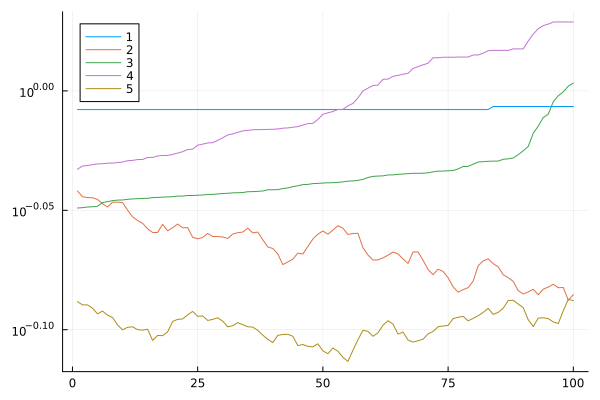

In [43]:
plot(firms[1].stockPriceLog[end-99:end], label="1", yscale=:log10)
plot!(firms[2].stockPriceLog[end-99:end], label="2", yscale=:log10)
plot!(firms[3].stockPriceLog[end-99:end], label="3", yscale=:log10)
plot!(firms[4].stockPriceLog[end-99:end], label="4", yscale=:log10)
plot!(firms[5].stockPriceLog[end-99:end], label="5", yscale=:log10)

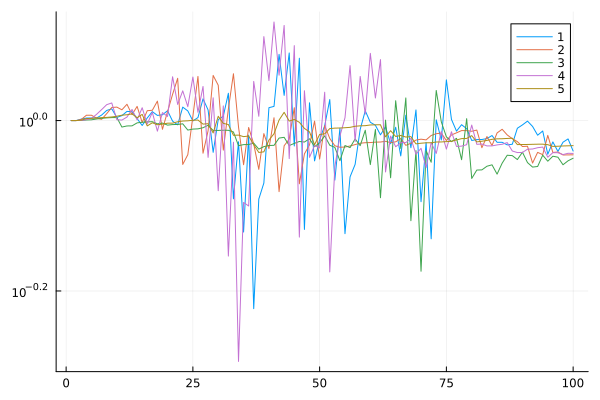

In [44]:
plot(firms[1].stockPriceLog[1:100], label="1", yscale=:log10)
plot!(firms[2].stockPriceLog[1:100], label="2", yscale=:log10)
plot!(firms[3].stockPriceLog[1:100], label="3", yscale=:log10)
plot!(firms[4].stockPriceLog[1:100], label="4", yscale=:log10)
plot!(firms[5].stockPriceLog[1:100], label="5", yscale=:log10)

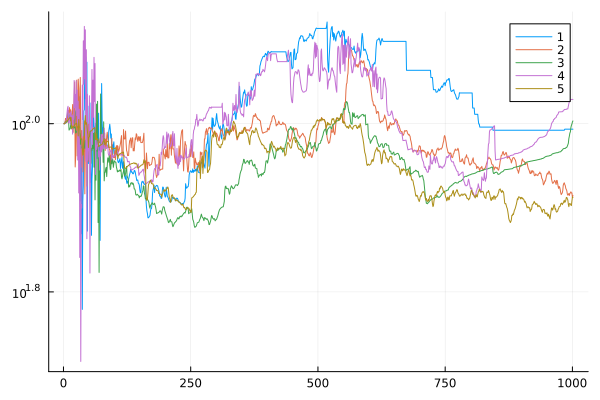

In [45]:
plot(firms[1].stockPriceLog.*firms[1].stockQuantityLog, label="1", yscale=:log10)
plot!(firms[2].stockPriceLog.*firms[2].stockQuantityLog, label="2", yscale=:log10)
plot!(firms[3].stockPriceLog.*firms[3].stockQuantityLog, label="3", yscale=:log10)
plot!(firms[4].stockPriceLog.*firms[4].stockQuantityLog, label="4", yscale=:log10)
plot!(firms[5].stockPriceLog.*firms[5].stockQuantityLog, label="5", yscale=:log10)

In [46]:
agents

100-element Vector{Agent}:
 Agent("fundamentals", 0.5961550472406314, [-1.8856816851142805e-40, 1.7750803238003932, 52.48542642411739, 0.12799603626594958, 3.9698864785414476, 1.5097740205116437, 0.0, 0.0, -13.836016206011275, -6.343626004805198], [-1.857454311734946e-40, 1.4585404199734966, 52.87884104560248, 0.13678593890105725, 3.243215822213577, 1.161141894650212, 0.0, 0.0, -15.114623157622814, -5.566550705071518], [20.0, 20.0, 20.012254598030765, 20.046966593410517, 20.0587155238495, 20.076721345061543, 20.11567176494274, 20.200669473476633, 20.210844197084235, 19.958572606628167  …  35.59718117741114, 36.215401306691405, 36.56691285135316, 36.97660299344545, 37.12941308007462, 37.735159189634295, 38.05977236456482, 38.31829709599602, 38.63546760301629, 38.793506305887114], [0.26894772745508366, 0.9440554931890898, 1.2183392082698212, 38.0], [104.50768698855805, 56.106380790632244, 142.27560652088556, 158.82917727799847, 53.05530293988651, 60.497330150093575, 103.60433040849628, 1

In [47]:
firms

10-element Vector{Firm}:
 Firm(0.9850306795668835, 100.0, [1.0, 1.0, 1.004011571901223, 1.0067851533460555, 1.0067851533460555, 1.0067851533460555, 1.0149402157737035, 1.0276984527108934, 1.0321862794896464, 1.00845223558898  …  0.9850306795668835, 0.9850306795668835, 0.9850306795668835, 0.9850306795668835, 0.9850306795668835, 0.9850306795668835, 0.9850306795668835, 0.9850306795668835, 0.9850306795668835, 0.9850306795668835], [100.0], 98.50306795668835, 95.19498239590733, Any[(0.8509150596004628, 4.1904460219787917e-38, 18), (0.865389249154519, 12.932660880513383, 51), (0.8788785674349145, 8.128284274970255, 30), (0.8822950779280285, 1.0394410571613324, 36), (0.8860163440042416, 6.577224237264915, 50), (0.8871758244692438, 0.40391548372399827, 97), (0.8886379464238573, 0.13753984934962082, 84), (0.8901318939666973, 0.04344524752947366, 40), (0.8922179936474072, 0.037109712895015586, 21), (0.8935170930377941, 0.20740756736523494, 80)  …  (0.9586754246090908, 3.6012327838828615e-5, 75), 

In [48]:
money_sum = 0
for agent in agents
    money_sum += agent.money
end
money_sum

999.9999999999892

In [49]:
for firm in firms
    println(firm.hiddenCorporateValue)
end

95.19498239590733
49.89477468114762
139.5875414582606
179.52149303491973
52.74651605622369
52.31351818841579
112.14636824880883
121.3596102209859
113.26974528774458
76.34855091179216


In [50]:
for firm in firms
    println(firm.marketCapitalization)
end

98.50306795668835
82.16757294964579
100.74956925815184
106.8673240918524
81.6954298251155
76.90832395279364
100.95292129218106
105.17241561689362
109.24114956627493
87.75029771387757


In [51]:
for agent in agents
    println(agent.fundamentals)
end

[104.50768698855805, 56.106380790632244, 142.27560652088556, 158.82917727799847, 53.05530293988651, 60.497330150093575, 103.60433040849628, 141.67608925537397, 119.58481663524911, 91.27208564563148]


[106.96569994363699, 61.0540633077703, 137.3000663132575, 180.62524233617222, 57.89555164393454, 75.84361159968705, 89.36159405488262, 164.80046348061364, 121.92952290724382, 90.20141881882975]
[116.84728180551306, 58.459566322049874, 146.95481936373366, 172.15863573404908, 49.36195118266228, 57.66148782534177, 100.18318347405506, 170.89247465861098, 121.92820301215717, 82.30665633889166]
[99.94673201613571, 48.77495948434036, 155.21885797967877, 200.30573440088568, 55.619619247826165, 66.98981535132076, 102.40104294523792, 188.69725571483752, 116.35685764330927, 82.61651232013377]
[102.68234682137711, 60.33139833290745, 141.36269279582993, 151.59784866205004, 47.83422590455229, 61.019573475843046, 107.09278051090975, 152.14610805692138, 141.81260341938616, 89.22876706378509]
[106.55696310002689, 55.72961189433234, 136.49762347775504, 160.65473443824067, 54.24827213323586, 63.36043704296046, 100.2346147206437, 160.2632246204767, 128.62452936357823, 95.2778176374219]
[106.3558436900069

 158.32650927952517, 44.519479490854486, 68.12371692971692, 107.28846026654789, 134.37101224648168, 113.96051056656506, 86.86375324622234]
[109.90265921123589, 52.12619301177208, 139.24709358913395, 151.1243623719872, 57.48137548779256, 62.66564170037373, 106.23759652318648, 162.53766218816307, 123.84722844569158, 82.24687667855393]
[112.40543669981587, 53.399514184110515, 135.1208199496255, 164.17961560882776, 50.95771915549923, 66.02541465786781, 102.65624728958235, 168.50163032801714, 128.57609289738377, 86.49469327602121]
[104.98519071688158, 62.66462180627484, 134.72919833616064, 168.8989803214968, 58.9904591992153, 58.011479560696124, 108.2861747698955, 169.79418346780227, 107.74046086250377, 92.1170303016671]
[103.42951803215071, 50.1362541870406, 125.19809410570303, 153.00357944477065, 46.62786245944031, 61.71667349459466, 100.43486541082055, 189.73826824247064, 124.2827479521404, 82.38415747410458]
[95.32806022970857, 50.04250244301106, 145.11335301687387, 144.88485678761145, 

, 135.55390451421172, 171.14345911681582, 59.94183695210645, 62.33636449013337, 96.72150262762499, 167.96629076226395, 115.67573012462684, 87.46187547124802]
[90.69145558696965, 54.090448666261445, 137.20542551279425, 149.32015812032694, 50.81459287840469, 63.4807672487324, 91.23433409786237, 179.10569896245943, 112.72210878631257, 93.87922668345236]
[106.93686930144544, 56.80473108491993, 139.78131833733784, 157.45511670252264, 50.24285160650322, 71.14936352305752, 112.56246928269186, 169.17701285998788, 124.97073215740782, 90.63909745337357]
[98.09644110770904, 52.17422528374045, 125.99122966172902, 175.78822552449046, 51.45656555047762, 68.59865612760355, 116.9507540966349, 161.96502050121856, 119.4854547579267, 88.51615700705699]
[101.34502213353235, 53.72934942749613, 141.60953121784266, 188.68990599165116, 54.54639782879637, 61.62321161859407, 93.8486709756104, 176.6855949325701, 129.3169123951916, 83.61129187772035]
[104.13604551046816, 53.917413804854235, 134.66779187209045, 14

115.644168874822, 160.4695492985036, 123.65068366429374, 86.03616581768355]
[104.31383709774664, 48.461873195943475, 116.67597336396247, 163.6494946447421, 49.53145574268814, 57.546060450183, 115.90876841526423, 175.23455114860715, 121.11302659851847, 77.95594762891734]
[97.58542483434326, 57.55807604209328, 129.55291462087774, 178.57158776336695, 43.413682917368035, 61.70316844920458, 101.27563152854928, 147.4060077953879, 121.4435362800933, 77.09993938843533]
[96.40845608097716, 51.5310287667203, 134.80608736885316, 187.97176889412796, 58.78177290972886, 65.12107448827108, 105.42469846634565, 163.60573141994368, 113.37505747568302, 89.93307350762905]
[95.22962953957648, 52.95645663767453, 146.09322388163037, 185.1051490934853, 50.47238132861476, 63.95078386988876, 97.2028291057577, 173.32477660744127, 136.2512916029394, 87.8256281675384]
[95.52357225373606, 53.830006953146686, 138.40075842315468, 159.53100373520297, 53.345107644016245, 62.90760196634289, 101.59274468939418, 151.79536

, 51.28542039607702, 135.73521680090528, 185.90553346102897, 51.52704908692408, 61.400496771769426, 109.49472381214345, 156.5889663918149, 127.8465508389323, 91.00395488721747]
[102.11383203233807, 50.745667450978935, 153.57479730612567, 163.2020217405977, 48.148999690667466, 63.27447202349706, 98.8846694239466, 174.62311396315215, 117.04965076867234, 90.13000375815216]
[107.25076624771013, 59.65440391748219, 119.61362135903828, 141.4927014869195, 57.086832535055265, 62.204744954825316, 112.67266222155618, 166.57003948919265, 121.41439132654604, 88.12267710552705]
[101.11126690429721, 51.153513638572306, 130.46105462139096, 165.8961213816042, 49.2772899937963, 73.74691176510433, 110.46344851255921, 152.44612149738458, 146.2176500016649, 93.41329995931552]
[107.55743929631173, 58.86997811877209, 131.66049047155454, 165.69951631140708, 54.68906988587255, 65.66791847504474, 100.58555161939418, 147.09238558218178, 143.5422615606682, 78.70020084415997]
[101.22214160152743, 60.65479071848112

, 83.85245863509981]
[112.380788430665, 53.20567534470279, 137.77195699126338, 173.46495700273806, 49.46847112543755, 60.85346629033058, 100.20947177204079, 171.9099502337894, 123.06239009058982, 80.31416203626004]
[109.4635269108074, 63.21501958819671, 134.30817435681067, 156.18128589904038, 52.19273142553594, 62.784159649632414, 97.51197944551177, 162.08372453496548, 116.10252355649227, 86.09859515620148]
[105.71009936246315, 51.1397362475903, 140.94995054063594, 155.343865413454, 51.00882303480581, 69.11235560365296, 103.76494967548702, 185.93990737207568, 136.42253933722964, 80.41843199771992]
[105.33762702397877, 53.45078305403196, 140.11784013886975, 178.8380934268887, 49.08861546203099, 57.03243851372994, 112.53511559918026, 162.92057204354845, 119.46166305152902, 88.04339178663966]
[115.48783902867426, 56.24799248041194, 134.07272421107285, 181.60559040134564, 52.83279705613684, 66.67467693175793, 109.90427902904067, 154.83518230162696, 105.62108270336658, 86.84540187304695]
[1

 159.83203975513848, 128.27218414999302, 81.7365888701457]
[110.96328837212742, 57.39352961331285, 127.93308299640375, 159.72685885575348, 52.991719458077654, 51.97329448606695, 89.01697334573147, 171.81429576191525, 122.03745296584898, 92.1151744964992]
[94.19035158607387, 55.12485370771001, 143.15653305142294, 167.86145547205652, 47.742209043534054, 61.356442748185245, 100.81183834941213, 164.59510674161206, 114.39410910204116, 90.09934450932354]
[104.0847031988728, 47.85660087908905, 145.03658984335564, 163.84119643769924, 47.420828395652656, 66.6413531955955, 110.95678673613222, 156.98692797307464, 140.86637354991112, 90.21639563931772]
[95.1815919011315, 56.49222024327256, 134.71234008789784, 157.4921059674713, 48.28434996362589, 61.466143705149356, 103.8173736649434, 169.0868991894256, 116.86605616822258, 86.32138567386703]
[103.91744929301447, 53.16490339439914,

 131.44427042540644, 183.67013920000147, 58.59281297678154, 67.28620610546028, 96.91102905596996, 178.23807924064698, 120.67675806987351, 81.99310462727924]
[107.80966768142339, 59.53967091860795, 136.85034184034808, 177.95179569837026, 48.592468579756456, 66.52138551182192, 109.69754664879814, 172.7170308687065, 121.86375810913425, 84.94710025621272]
[97.26285531851485, 54.35179576252714, 146.85930090885918, 157.94619447618712, 55.975060072623954, 62.86706712412663, 92.33449804656969, 158.34879674190645, 116.25946452913422, 93.2320169651298]
[97.90109346251025, 62.99946766713084, 124.13377982120751, 143.83762729233882, 49.429962663406926, 65.78067888491603, 108.53437009946568, 172.68000669064165, 119.03262069658379, 90.45251301771124]
[105.1070038054283, 49.28908567584975, 140.5579950482676, 163.06256707625448, 52.98021004225124, 65.83587335069609, 106.45187319961131, 177.15309725176476, 118.38367582148946, 102.7989374190959]
[100.53917293516241, 49.912091936265334, 156.3190610372894,

, 154.68543585691225, 105.25947581227433, 79.22452132808309]
[94.83980939648177, 49.07694084655979, 130.33717523312419, 155.77158722562706, 55.797344613852694, 64.36412577095524, 91.85647031579782, 169.08123496390886, 130.81076624069468, 82.97694243508843]
[98.88808777349277, 53.69635383244687, 137.27978750141523, 170.0946438952784, 51.54831228176716, 56.1722123693871, 108.5099361375989, 171.28662902381132, 132.55771289532385, 84.01775425070717]
[124.86220599084228, 52.893771758752465, 153.9754080534348, 147.34178986006486, 52.33806570553426, 59.71750028374645, 100.8615821436752, 165.2509920301102, 115.0744930962664, 82.9503597842648]
[106.83833237064286, 54.85018178184983, 141.4477189988048, 190.14355549055313, 52.375524296506654, 57.92730520035891, 113.03889449027737, 180.1484231955671, 127.58857067124947, 81.72474034251108]
[113.60428128551276, 58.07205059747196, 142.14436375099646, 178.16820274390014, 55.69347675213301, 64.30209317427568, 104.53518448181744, 170.99825265329454, 123

[109.51487490651073, 54.516629426998705, 137.26840580547602, 151.06415012607758, 47.39140443428952, 68.42978349139122, 94.3530837368385, 188.52729192314675, 125.51952664527879, 78.93209693716041]
[95.79028314810961, 60.456657139412584, 128.69154593133484, 183.09220689724822, 56.09109944561077, 69.57892679558213, 101.17630116385212, 170.63291039591346, 115.6135848587679, 86.11688032071733]
[106.33378876497041, 57.82214761953155, 124.56119171579257, 176.66624654884995, 56.29810830732884, 76.15850058601585, 120.27063451922984, 174.05832965867108, 125.79549323250053, 92.1597416645315]
[103.19148518017305, 51.536345343730964, 141.15210257756985, 173.4367742285903, 55.23716985578829, 54.457675349921345, 109.68608949029974, 144.8127899150184, 129.31298646603153, 89.24677858230442]
